In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (MobileNetV2, ResNet50, InceptionV3, VGG16, EfficientNetB0, DenseNet121)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter('ignore')

# **1- Data preparation**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Basic settings
    </font>
</div>

In [3]:
img_width, img_height = 224, 224  # Image dimensions for the models
batch_size = 16
epochs = 5

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Dataset path
    </font>
</div>

In [4]:
train_data_dir = '/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres'

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Data preprocessing
    </font>
</div>

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=0.2  # Split data into training and validation sets
)

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Generate training data
    </font>
</div>

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (healthy or defective)
    subset='training'  # Training data
)

Found 1486 images belonging to 2 classes.


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Generate validation data
    </font>
</div>

In [7]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Validation data
)

Found 370 images belonging to 2 classes.


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Display sample images
    </font>
</div>

In [8]:
def plot_sample_images(generator, num_images=8):
    images, labels = next(generator)  # Get a batch of images and labels
    class_names = list(generator.class_indices.keys())  # Class names
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[int(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Display sample images from the training data
    </font>
</div>

Sample training images:


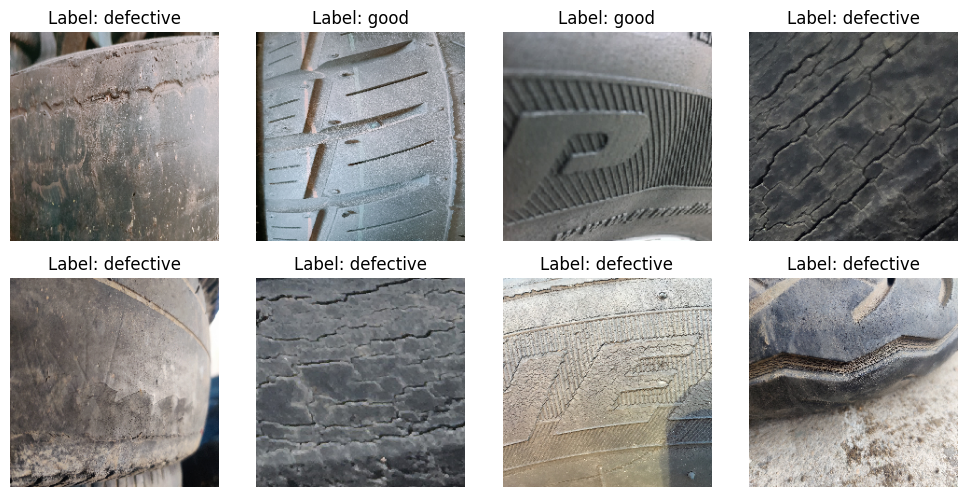

In [9]:
print("Sample training images:")
plot_sample_images(train_generator)

# **2- Pre-trained Models**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Function to build a model using a pretrained base model
    </font>
</div>

In [10]:
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
    x = Dense(1024, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    predictions = Dense(1, activation='sigmoid')(x)  # Binary output (healthy or defective)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
List of pretrained models
    </font>
</div>

In [11]:
models = {
    'MobileNetV2': MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
    'DenseNet121': DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
}

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Train and evaluate each model
    </font>
</div>

In [12]:
results = {}
for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    
    # Build the model
    model = build_model(base_model)
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epochs,
        verbose=1
    )
    
    # Save the results
    results[model_name] = history.history

Training MobileNetV2...
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7955 - loss: 0.5205 - val_accuracy: 0.8125 - val_loss: 0.5065
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.3305 - val_accuracy: 1.0000 - val_loss: 0.1176
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9192 - loss: 0.2181 - val_accuracy: 0.7826 - val_loss: 0.5396
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.8750 - loss: 0.4281 - val_accuracy: 1.0000 - val_loss: 0.0545
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9371 - loss: 0.1396 - val_accuracy: 0.8043 - val_loss: 0.5239
Training ResNet50...
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.5370 - loss: 0.9210 - val_accuracy: 0.6766 - val_loss: 0.5860
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4375 - loss: 0.8453 - val_accuracy: 0.5000 - val_loss: 0.8582
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.6017 - los

# **3- Plot accuracy and loss for each model**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Accuracy plot
    </font>
</div>

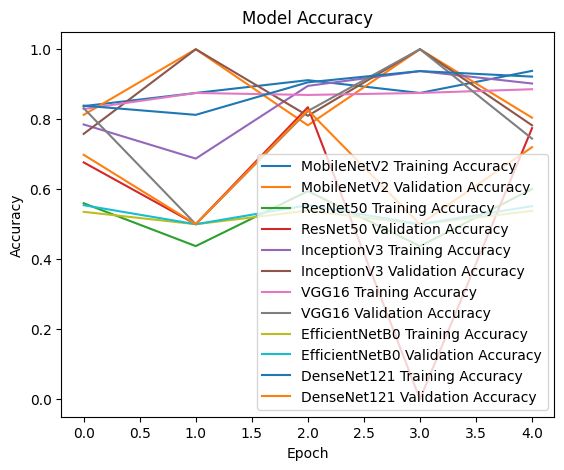

In [13]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for model_name, history in results.items():
    plt.plot(history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history['val_accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Loss plot
    </font>
</div>

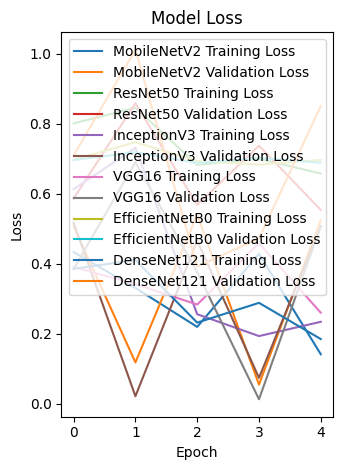

In [14]:
plt.subplot(1, 2, 2)
for model_name, history in results.items():
    plt.plot(history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history['val_loss'], label=f'{model_name} Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<div style="background-color: gray; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
If my notebook was useful for you, please give me a upvote. Thank you for your support ❤️
    <hr style="color: green;"></font>
    <font size="6px">
        <a href="https://omidsakaki.ir/">Website</a>
        <br/>
         <a href="https://github.com/omid-sakaki-ghazvini">Github</a>
        <br/>
        <a href="http://linkedin.com/in/omid-sakaki-ghazvini-378687217">linkedin</a> 
    </font>
</div>